In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from dateutil.relativedelta import relativedelta

import mysql.connector

import gcGroupbyExtension

from config import Cfg as cfg

%matplotlib inline

## Race results

In [117]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

In [118]:
len(df_results.athlete.unique())

643055

## Races info

In [119]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

In [95]:
# df_results.loc[df_results.race == "Vietnam70.3"]

### Some processing on the datasets

In [123]:
# -----------
# -- RACES --
# -----------


# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# remove duplicates
df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races['race'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from before 2019
df_results = df_results.loc[df_results['year'] < 2019]

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]


/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/miniconda3/envs/data-science/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

### what do we have left to work with?

In [124]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1654265
  Number of athletes: 579934
-- Races dataset --
  Number of active races: 160


## Add Race count per athlete

In [125]:
# query = '''SELECT *
# FROM (
#          SELECT athlete, count(*) as count_races
#          FROM results
#          GROUP BY athlete
#      ) as t1
# ORDER BY count_races DESC'''

# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)
# athletes_race_count = pd.read_sql(query, con=cnx)
# cnx.close()

athletes_race_count = (df_results.groupby('athlete')['division']
     .count()
     .reset_index()
     .rename(columns={'division': 'number_of_races'})
     .sort_values(by="number_of_races", ascending=False)
)

athletes_race_count.head(10)

,athlete,number_of_races
525141,Taiwan Triathlete,686
132025,David Smith,179
129312,David Jones,166
389447,Michael Smith,164
267967,John Wragg,138
492408,Scott Smith,134
69405,Brian Smith,129
384019,Michael Brown,124
32305,Andrew Smith,115
129754,David Lee,114


The `Taiwan Thriathlete` is what the iRonMan website entered for every Taiwainese athlete ... and then there are probably several David Smith, Michael Smith, etc ... need to find a solution to isolated each one. Maybe using age group?

In [126]:
final_df_results = df_results.merge(athletes_race_count, left_on="athlete", right_on="athlete", how="left")
final_df_results.head(5)

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,country,date,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,2016,16
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,2016,16
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,2016,31
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,2016,24
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,2016,10


#### Let's get rid of anyone that has more than 100 races. We cannot really trust those data

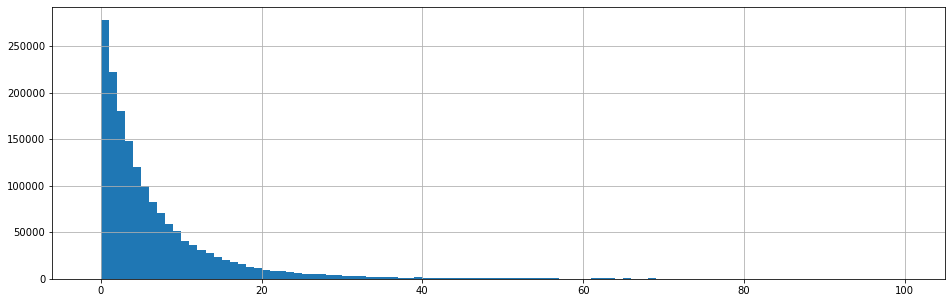

In [127]:
final_df_results = final_df_results.loc[final_df_results['number_of_races']<=100]

final_df_results['number_of_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(16, 5))

A majority of athletes have < 20 races

## We need to make a `profile` for each athlete. What features could we extract from the data we have?

## Years in sport

In [128]:
years_in_sport = (final_df_results
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('years_in_sport') 
)

final_df_results = final_df_results.merge(years_in_sport, left_on="athlete", right_on="athlete", how="left")
final_df_results['years_in_sport'] = final_df_results.years_in_sport.astype(int)
final_df_results.head(5)

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,date,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,2016-11-13,0,98.4,100.0,86.1,100.0,M,2016,16,16
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,2016-11-13,0,97.1,77.2,100.0,90.7,M,2016,16,15
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,2016-11-13,0,99.9,100.0,100.0,99.7,M,2016,31,12
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,2016-11-13,0,100.0,100.0,100.0,100.0,M,2016,24,13
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,2016-11-13,0,99.6,100.0,98.3,99.0,M,2016,10,4


## Active years in sport

In [129]:
active_years = (
    final_df_results
        .groupby(['athlete', 'year'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("active_years_in_sport")
)

final_df_results = final_df_results.merge(active_years, left_on="athlete", right_on="athlete", how="left")
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,0,98.4,100.0,86.1,100.0,M,2016,16,16,9
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,0,97.1,77.2,100.0,90.7,M,2016,16,15,10
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,0,99.9,100.0,100.0,99.7,M,2016,31,12,12
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,0,100.0,100.0,100.0,100.0,M,2016,24,13,13
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,0,99.6,100.0,98.3,99.0,M,2016,10,4,4


## Avg number of race per active year

In [130]:
final_df_results['avg_n_races_year'] = final_df_results['number_of_races']/final_df_results['active_years_in_sport']
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,98.4,100.0,86.1,100.0,M,2016,16,16,9,1.777778
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,97.1,77.2,100.0,90.7,M,2016,16,15,10,1.600000
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,99.9,100.0,100.0,99.7,M,2016,31,12,12,2.583333
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,100.0,M,2016,24,13,13,1.846154
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,99.6,100.0,98.3,99.0,M,2016,10,4,4,2.500000


## Unique races (percentage that don't overlap)

In [131]:
unique_races = (
    final_df_results
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("unique_races_number")
)

final_df_results = final_df_results.merge(unique_races, left_on="athlete", right_on="athlete", how="left")
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year,unique_races_number
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,86.1,100.0,M,2016,16,16,9,1.777778,8
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,77.2,100.0,90.7,M,2016,16,15,10,1.600000,9
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,100.0,99.7,M,2016,31,12,12,2.583333,14
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,M,2016,24,13,13,1.846154,6
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,100.0,98.3,99.0,M,2016,10,4,4,2.500000,7


In [132]:
final_df_results['unique_races_percentage'] = final_df_results['unique_races_number']/final_df_results['number_of_races']
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year,unique_races_number,unique_races_percentage
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,86.1,100.0,M,2016,16,16,9,1.777778,8,0.500000
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,100.0,90.7,M,2016,16,15,10,1.600000,9,0.562500
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,99.7,M,2016,31,12,12,2.583333,14,0.451613
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,M,2016,24,13,13,1.846154,6,0.250000
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,98.3,99.0,M,2016,10,4,4,2.500000,7,0.700000


## Internationality of the racer?

In [243]:
tempo = (final_df_results
         .groupby(['athlete', 'race'])
         .size()
         .reset_index()
        )

# remplace the race by its region
region_hash = {
    race: region for race,region in df_races[['race', 'region']].values
}

tempo.loc[:, 'race'] = tempo.loc[:, 'race'].apply(lambda x: region_hash[x])

internationality = (
    tempo
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("n_regions_raced")
)

final_df_results = final_df_results.merge(internationality, left_on="athlete", right_on="athlete", how="left")
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year,unique_races_number,unique_races_percentage,n_regions_raced
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,100.0,M,2016,16,16,9,1.777778,8,0.500000,4.0
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,90.7,M,2016,16,15,10,1.600000,9,0.562500,5.0
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,99.7,M,2016,31,12,12,2.583333,14,0.451613,4.0
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,M,2016,24,13,13,1.846154,6,0.250000,4.0
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,99.0,M,2016,10,4,4,2.500000,7,0.700000,3.0


In [247]:
# 
final_df_results["internationality_score"] = final_df_results["n_regions_raced"]/final_df_results["unique_races_number"]
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year,unique_races_number,unique_races_percentage,n_regions_raced,internationality_score
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,M,2016,16,16,9,1.777778,8,0.500000,4.0,0.500000
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,M,2016,16,15,10,1.600000,9,0.562500,5.0,0.555556
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,M,2016,31,12,12,2.583333,14,0.451613,4.0,0.285714
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,M,2016,24,13,13,1.846154,6,0.250000,4.0,0.666667
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,M,2016,10,4,4,2.500000,7,0.700000,3.0,0.428571


# SAVE FILE

In [248]:
# save final
final_df_results.to_csv("./../data/clean/entrants_info_features.csv", index=False)

In [249]:
len(final_df_results)

1651674